# Project 4 - Advanced Lane Lines

### Load Libraries and Variables

In [1]:
# Import libraries
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
import numpy as np
import cv2
from matplotlib import pyplot as plt

print("Libraries imported!")

Libraries imported!


In [2]:
# Load matricies to undistort images
mtx = pickle.load(open("cameraMatrix.p", "rb"))
dist = pickle.load(open("distortionCoeff.p", "rb"))
M = pickle.load(open("perspectiveMatrix.p","rb"))
Minv = pickle.load(open("perspectiveMatrixInv.p","rb"))
print("Camera Distortion Matricies Imported")

Camera Distortion Matricies Imported


### Functions for Preprocessing

In [3]:
# Function copied from P1
def maskImages(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [4]:
def createBinary(image, thresh):
    binary = np.zeros_like(image)
    binary[(image>=thresh[0]) & (image<= thresh[1])] = 1
    return binary

In [5]:
def undistortImage(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

In [6]:
def colorspace(image):
    S = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
    B = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)[:,:,2]
    L = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)[:,:,0]
    S = createBinary(S, (170, 250))
    B = createBinary(B, (160, 255))
    L = createBinary(L, (210, 255))
    binaryCombined = np.zeros_like(S)
    binaryCombined[(B==1) | (L==1)] = 1 #(S==1) | 
    return binaryCombined

In [7]:
def gradient_abs(image, orient='x', sobel_kernel=3, thresh=(0,255)):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # absolute gradient
    sobelAbs = np.absolute(sobel)
    sobelScaled = np.uint8(255*sobel/np.max(sobelAbs))
    
    return createBinary(sobelScaled, thresh)

def gradient_mag(image, sobel_kernel=3, thresh=(0,255)):
    # convert images to grayscale, could try other colorspaces (S, V)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    gradmag = np.uint8(255*gradmag/np.max(gradmag))
    
    return createBinary(gradmag, thresh)
    
def gradient_dir(image, sobel_kernel=3, thresh=(0,255)):
    # convert images to grayscale, could try other colorspaces (S, V)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Direction
    sobelAngle = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    return createBinary(sobelAngle, thresh)

In [8]:
def gradient(image):
    grad_absX = gradient_abs(image, orient='x', sobel_kernel=15, thresh=(20,200))
    grad_absY = gradient_abs(image, orient='y', sobel_kernel=15, thresh=(20,200))
    grad_mag = gradient_mag(image, sobel_kernel=15, thresh=(40,200))
    grad_dir = gradient_dir(image, sobel_kernel=15, thresh=(0.7,1.1))
    
    binaryCombined = np.zeros_like(grad_absX)
    binaryCombined[((grad_absX==1)&(grad_absY==1)) | 
                   ((grad_mag==1)&(grad_dir==1))] = 1

In [9]:
def perspective(image):
    return cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), 
                                   flags=cv2.INTER_LINEAR)

In [10]:
def preprocessImage(image):
    # Undistort Image
    undistort = undistortImage(image)
    # Create Combined Binary
    colorspaceBinary = colorspace(undistort)
    gradientBinary = gradient(undistort)
    binaryCombined = np.zeros_like(colorspaceBinary)
    binaryCombined[(colorspaceBinary==1)|(gradientBinary==1)] = 1
    
    # Mask to area of interest
    imshape = image.shape
    x_top=600
    x_bottom=70
    y=400
    vertices = np.array([[(x_bottom,imshape[0]),(x_top, y), (imshape[1]-x_top, y), (imshape[1]-x_bottom,imshape[0])]], dtype=np.int32)
    binaryMasked = maskImages(binaryCombined, vertices)
    
    binaryPerspective = perspective(binaryMasked)
    
    return binaryPerspective

### Lane Finding

In [11]:
def radiusOfCurvature(x,y):
    ymperpix = 30/720
    xmperpix = 3.7/580
    
    # Refit using meter
    coeffs = np.polyfit(y*ymperpix, x*xmperpix, 2)
    
    yeval = np.max(y)*ymperpix
    # Calc radius of curvature
    Rcurve = ((1 + (2*coeffs[0]*yeval + coeffs[1])**2)**1.5) / (2*coeffs[0])
    
    # Calc line distance top and bottom
    basePos = coeffs[0]*yeval**2 + coeffs[1]*yeval + coeffs[2]
    yeval = np.min(y)*ymperpix
    topPos = coeffs[0]*yeval**2 + coeffs[1]*yeval + coeffs[2]
    
    return Rcurve, basePos, topPos

In [12]:
def findLanesWindowSlide(image):
    imshape = image.shape
    histogram = np.sum(image[imshape[0]//2:,:], axis=0)
    outImg = np.dstack((image, image, image))*255
    # Get the left and right lane bases
    midpoint = np.int(histogram.shape[0]/2)
    leftlaneBase = np.argmax(histogram[:midpoint])
    rightlaneBase = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set up windows to analyse with
    nwindows = 9
    windowHeight = np.int(imshape[0]/nwindows)
    windowWidth = 100
    
    # Get non zero pixels in image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Start Position
    left_current = leftlaneBase
    right_current = rightlaneBase
    
    # Number of pixels to recenter window
    minpix = 500
    
    # Lists for indicies
    leftLane_idx = []
    rightLane_idx = []
    
    # Step through each window
    for window in range(nwindows):
        # Bounderies
        winY_low = imshape[0] - (window+1)*windowHeight
        winY_high = imshape[0] - window*windowHeight
        winXL_low = left_current - windowWidth
        winXL_high = left_current + windowWidth
        winXR_low = right_current - windowWidth
        winXR_high = right_current + windowWidth
        
        # Draw windows on image
        cv2.rectangle(outImg, (winXL_low, winY_low), (winXL_high, winY_high), (0,255,0), 2)
        cv2.rectangle(outImg, (winXR_low, winY_low), (winXR_high, winY_high), (0,255,0), 2)
        
        # Pixels wihtin the window
        goodIdx_left = ((nonzeroy>=winY_low) & (nonzeroy<winY_high) & (nonzerox>=winXL_low) & (nonzerox<winXL_high)).nonzero()[0]
        goodIdx_right = ((nonzeroy>=winY_low) & (nonzeroy<winY_high) & (nonzerox>=winXR_low) & (nonzerox<winXR_high)).nonzero()[0]
        leftLane_idx.append(goodIdx_left)
        rightLane_idx.append(goodIdx_right)
        
        # Shift windows
        if len(goodIdx_left) > minpix:
            left_current = np.int(np.mean(nonzerox[goodIdx_left]))
        if len(goodIdx_right) > minpix:
            right_current = np.int(np.mean(nonzerox[goodIdx_right]))
        
    leftLane_idx = np.concatenate(leftLane_idx)
    rightLane_idx = np.concatenate(rightLane_idx)
    
    #extract pixels for polyfit
    leftx = nonzerox[leftLane_idx]
    lefty = nonzeroy[leftLane_idx]
    rightx = nonzerox[rightLane_idx]
    righty = nonzeroy[rightLane_idx]

    # Fit Line and radius of curvature
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    leftLane.radius_of_curvature, leftLane.basePos, leftLane.topPos = radiusOfCurvature(leftx, lefty)
    rightLane.radius_of_curvature, rightLane.basePos, rightLane.topPos  = radiusOfCurvature(rightx, righty)
    
    return left_fit, right_fit 

In [13]:
def findLanesLocal(image, coeffs_left, coeffs_right):
    # Get non zero pixels in image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Get pixels in margin around previous line
    margin = 100
    leftLine = coeffs_left[0]*(nonzeroy**2) + coeffs_left[1]*nonzeroy + coeffs_left[2]
    rightLine = coeffs_right[0]*(nonzeroy**2) + coeffs_right[1]*nonzeroy + coeffs_right[2]
    leftLane_idx = ((nonzerox > (leftLine - margin)) & (nonzerox < (leftLine + margin)))#.nonzero()[0] 
    rightLane_idx = ((nonzerox > (rightLine - margin)) & (nonzerox < (rightLine + margin)))#.nonzero()[0]
    
    #extract pixels for polyfit
    leftx = nonzerox[leftLane_idx]
    lefty = nonzeroy[leftLane_idx]
    rightx = nonzerox[rightLane_idx]
    righty = nonzeroy[rightLane_idx]

    # Fit Line and radius of curvature
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    leftLane.radius_of_curvature , leftLane.basePos, leftLane.topPos \
        = radiusOfCurvature(leftx, lefty)
    rightLane.radius_of_curvature, rightLane.basePos, rightLane.topPos  \
        = radiusOfCurvature(rightx, righty)
    return left_fit, right_fit 

### Image Pipeline

In [57]:
def drawLanes(image, leftCoeff, rightCoeff, binary):
    # Create image to draw on
    blankImage = np.zeros_like(image[:,:,0]).astype(np.uint8)
    blankImage = np.dstack((blankImage, blankImage, blankImage))
    
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    left_lane = leftCoeff[0]*ploty**2 + leftCoeff[1]*ploty + leftCoeff[2]
    right_lane = rightCoeff[0]*ploty**2 + rightCoeff[1]*ploty + rightCoeff[2]
    
    # Reformat points for drawing
    pts_left = np.array([np.transpose(np.vstack([left_lane, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_lane, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw lane onto image
    cv2.fillPoly(blankImage, np.int_([pts]), (0,255,0))
    
    # Warp back to original image space
    unwarped = cv2.warpPerspective(blankImage, Minv, (image.shape[1], image.shape[0]))
    # Combine with original image
    combined = cv2.addWeighted(image, 1, unwarped, 0.3, 0)
    
    # Calc and print Radius and dist from center
    if (abs(leftLane.radiusAverage) > 5000) | (abs(rightLane.radiusAverage) > 5000):
        aveRad = 'straight'
    else:
        aveRad = np.mean([leftLane.radiusAverage, rightLane.radiusAverage])
        aveRad = '{:.0f}m'.format(aveRad)
    cv2.putText(combined, "Left Curvature: {:.0f}m".format(leftLane.radius_of_curvature), 
                    (40,40), cv2.FONT_HERSHEY_COMPLEX, 0.8, (255,255,255),2)
    cv2.putText(combined, "Right Curvature: {:.0f}m".format(rightLane.radius_of_curvature), 
                    (40,70), cv2.FONT_HERSHEY_COMPLEX, 0.8, (255,255,255),2)
    cv2.putText(combined, "Mean Curvature: {}".format(aveRad), 
                    (40,120), cv2.FONT_HERSHEY_COMPLEX, 1.5, (255,255,255),4)
    cv2.putText(combined, "Dist from Center: {:.2f}m".format(leftLane.centerOffestAve), 
                    (40,160), cv2.FONT_HERSHEY_COMPLEX, 1.5, (255,255,255),4)
    
    # Add the binary to the top of the picture
    scale = 4
    binary = cv2.resize(binary, (int(image.shape[1]/scale), int(image.shape[0]/scale)))
    binaryStack = np.dstack((binary*255, binary*255, binary*255))
    combined[0:int(image.shape[0]/scale) ,int(image.shape[1]*(scale-1)/scale):image.shape[1]] = binaryStack
    return combined

In [30]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #polynomial coefficients for n samples
        self.pastCoeff = []
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        # collect of n samples of radius of curvature
        self.pastRadius = []
        # Ave radius of curvature over n samples
        self.radiusAverage = None
        # position of line bottom
        self.basePos = None
        # position of line top
        self.topPos = None
        #n samples of distance in meters of vehicle center from the center of the lane
        self.centerOffest = []
        # average base pos
        self.centerOffsetAve = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # store number of times the lane has been lost to restart the lane finding
        self.numMissed = 0
        

In [16]:
# a = []
# b = [1,2,3,4]
# c = [5,6,7,8]
# a.append(b)
# a.append(c)
# print(a)
# print(len(a))
# a.append(b)
# print(a)
# print(len(a))
# a.pop()
# print(a)
# d = (np.arange(1,11)/10)
# print(d)
# # d = [1,1,1,1,1,1,1,1,1,1]
# print(d)
# # d = d[::-1]
# # print(d)
# a = []
# for i in range(9):
#     a.append(b)
# a.append([10,11,12,13])
# print(a)
# f = np.average(a, 0, d)
# print(f)

In [64]:
def filterLanes(numSamples=10, maxMissed=10):
    # Get difference between top and bottom of mapped lines
    baseDist = rightLane.basePos - leftLane.basePos
    topDist = rightLane.topPos - leftLane.topPos
    distDiff = abs(baseDist-topDist)
    distMargin = 0.4
    
    # Get % diff between estimated radius of curvature
    radiusDiff = abs(abs(leftLane.radius_of_curvature)-abs(rightLane.radius_of_curvature))
    radiusMax = max(abs(leftLane.radius_of_curvature), abs(rightLane.radius_of_curvature))
    radiusPCentDiff = radiusDiff/radiusMax
    radiusMargin = 0.8
    
    # Predict using previous values if not a suitable line. Only if there are enough samples
    if ((distDiff > distMargin) | (radiusPCentDiff > radiusMargin)) \
        & len(leftLane.pastCoeff) >= numSamples:
        leftLane.numMissed += 1
        if leftLane.numMissed > maxMissed:
            leftLane.detected = False
            rightLane.detected = False
    else:
        leftLane.pastCoeff.append(leftLane.current_fit)
        rightLane.pastCoeff.append(rightLane.current_fit)
        leftLane.pastRadius.append(leftLane.radius_of_curvature)
        rightLane.pastRadius.append(rightLane.radius_of_curvature)
        leftLane.centerOffest.append((rightLane.basePos - leftLane.basePos) - (640*3.7/580))
        
        
        # If we have enough samples to start averaging, first removing the top value
        if len(leftLane.pastCoeff) > numSamples:
            leftLane.pastCoeff.pop(0)
            rightLane.pastCoeff.pop(0)
            leftLane.pastRadius.pop(0)
            rightLane.pastRadius.pop(0)
            leftLane.centerOffest.pop(0)
        
            # Get weighted average of the coefficients of the last n samples
            weights = (np.arange(1,numSamples+1)/numSamples)
            leftLane.best_fit = np.average(leftLane.pastCoeff, 0, weights)
            rightLane.best_fit = np.average(rightLane.pastCoeff, 0, weights)
            
            leftLane.radiusAverage = np.average(leftLane.pastRadius, 0, weights)
            rightLane.radiusAverage = np.average(rightLane.pastRadius, 0, weights)
            
            leftLane.centerOffestAve = np.average(leftLane.centerOffest,0, weights)
        else:
            # Set the best values to the current ones for plotting
            leftLane.best_fit = leftLane.current_fit
            rightLane.best_fit = rightLane.current_fit
            leftLane.radiusAverage = leftLane.radius_of_curvature
            rightLane.radiusAverage = rightLane.radius_of_curvature
            leftLane.centerOffestAve = leftLane.centerOffest[-1]
        
        leftLane.numMissed = 0
        leftLane.detected = True
        
    return

In [41]:
leftLane = Line()
rightLane = Line()
def processImage(image):
    binary = preprocessImage(image)
    
    if(leftLane.detected):
        leftLane.current_fit, rightLane.current_fit = findLanesLocal(binary, leftLane.best_fit, rightLane.best_fit)
    else:
        leftLane.current_fit, rightLane.current_fit = findLanesWindowSlide(binary)
    
    filterLanes()
    
    return drawLanes(image, leftLane.best_fit, rightLane.best_fit, binary)

In [63]:
fileOutput = 'test.mp4'
clip1 = VideoFileClip('project_video_hard.mp4')
processedVid = clip1.fl_image(processImage)
%time processedVid.write_videofile(fileOutput, audio=False)

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


100%|████████████████████████████████████████████████████████████| 231/231 [01:00<00:00,  3.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 

Wall time: 1min 1s


In [20]:
# from matplotlib import pyplot as plt
# clip1 = VideoFileClip('project_video.mp4')
# frame = clip1.get_frame(41.9)
# plt.figure(figsize=(15,15))
# plt.imshow(frame)
# plt.show()
# plt.imsave('./test_images/HardVidImage_temp.jpg', frame)

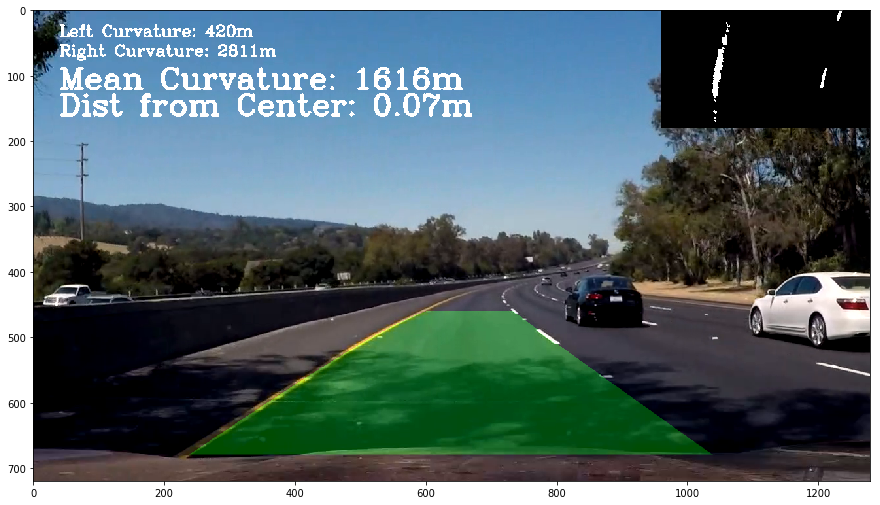

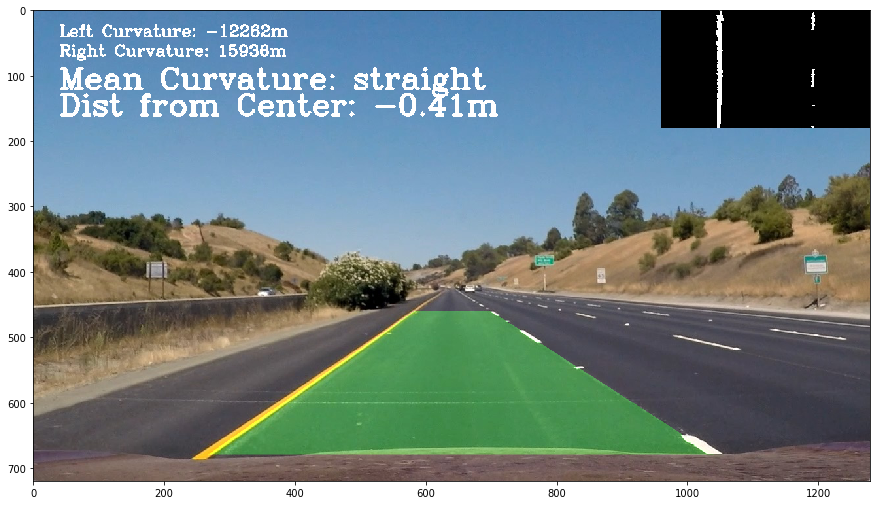

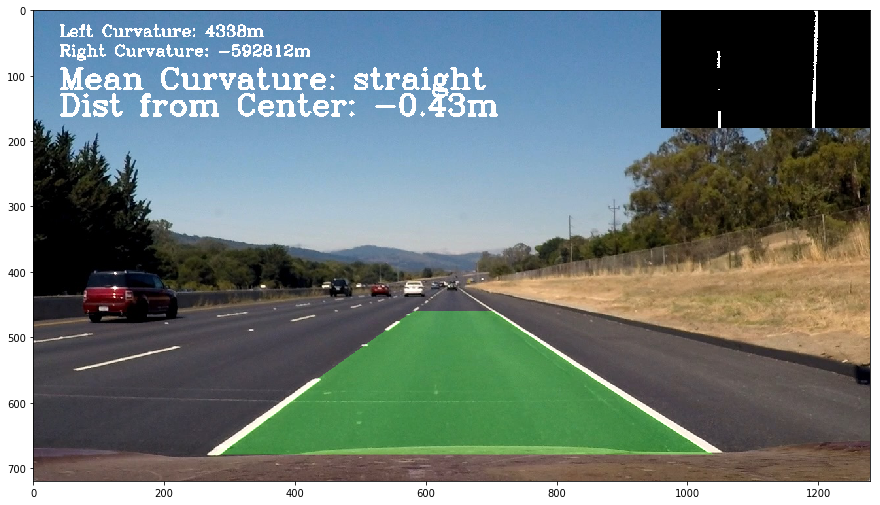

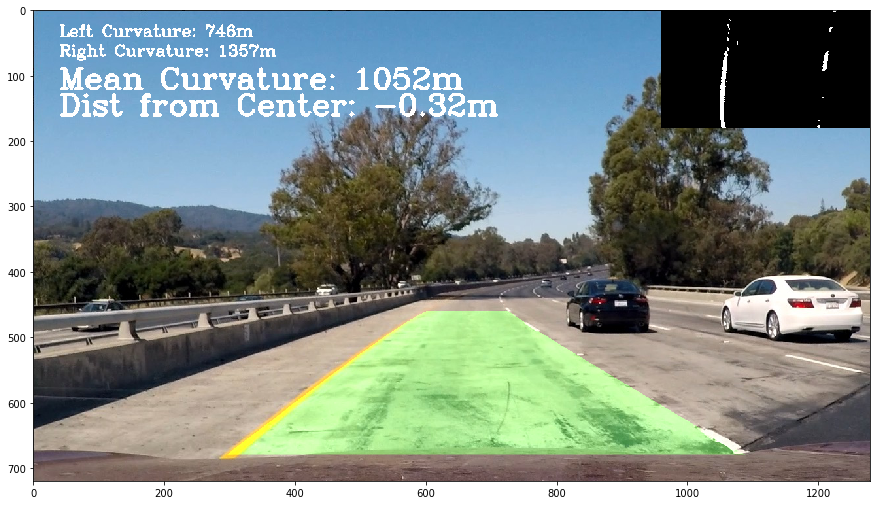

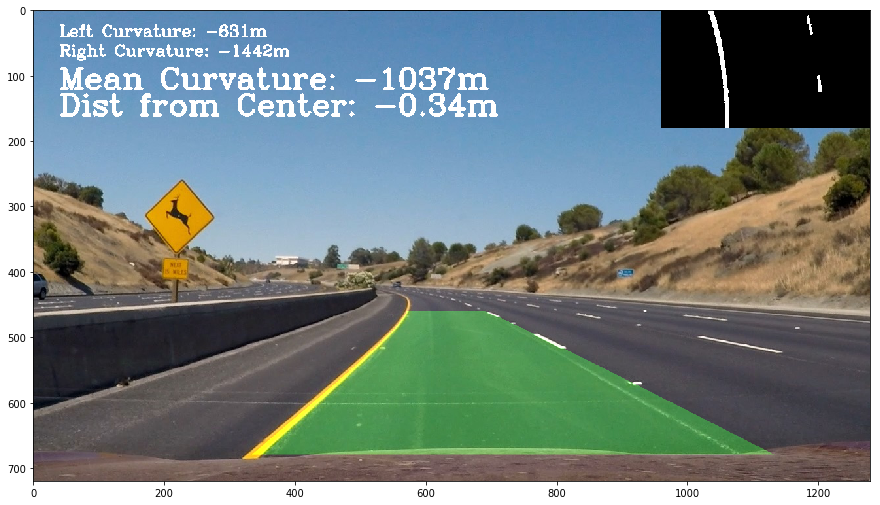

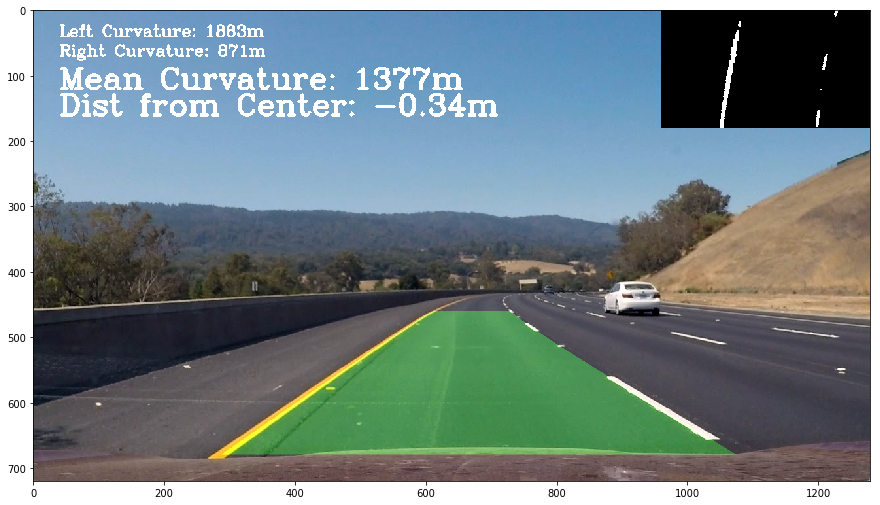

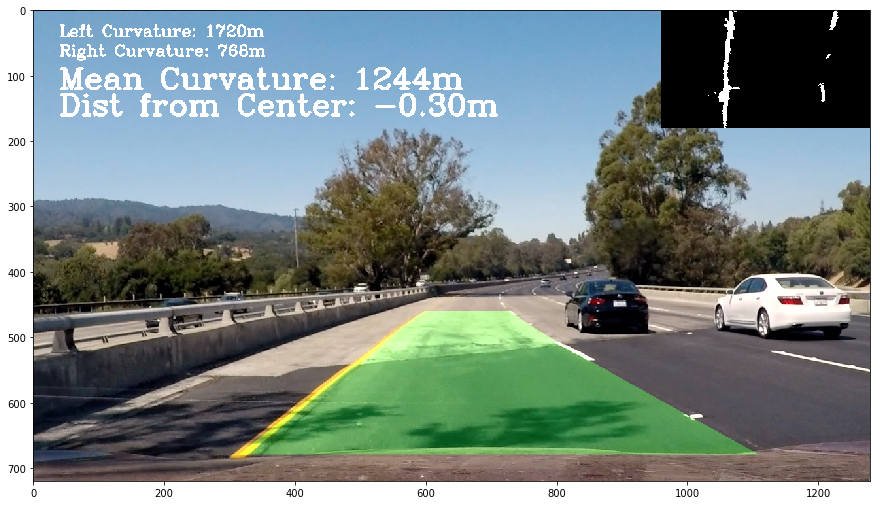

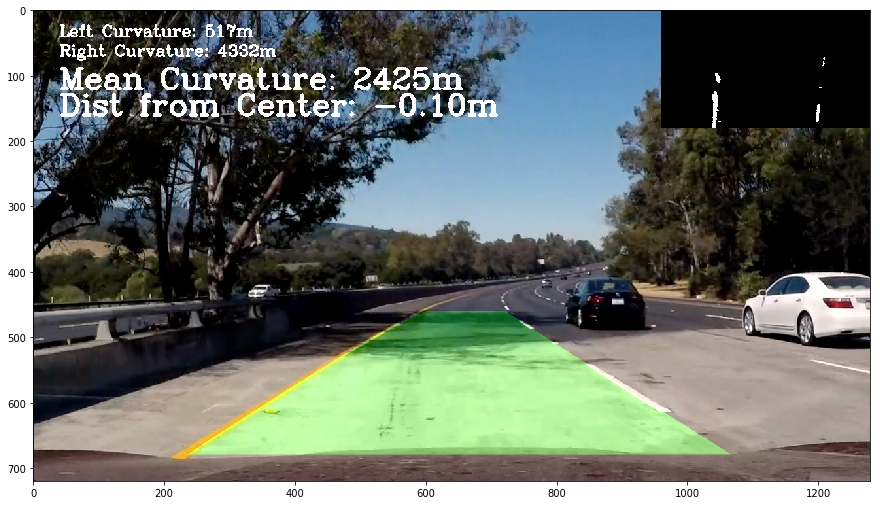

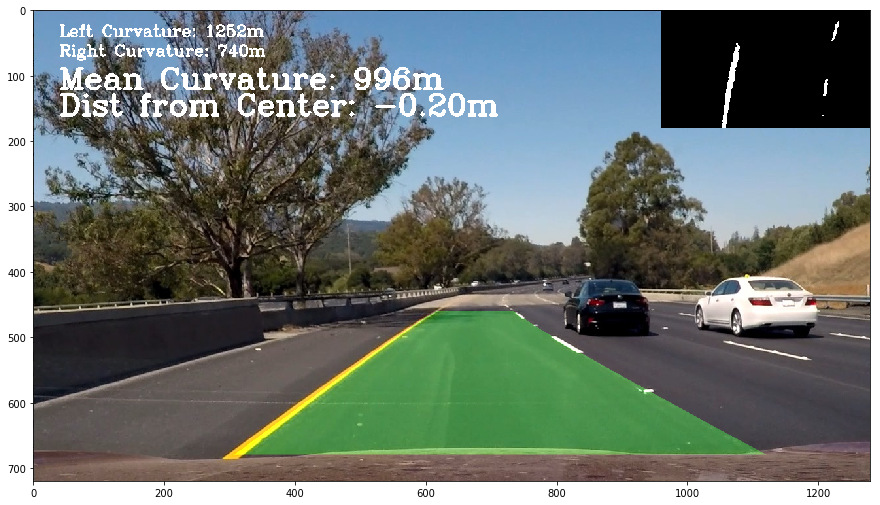

In [58]:
import os
# Load Test Images from file
filelist=[]
for file in os.listdir('./test_images/'):
    if file.endswith('.jpg'):
        filelist.append(file)
    
images = [cv2.imread('./test_images/{}'.format(image)) for image in filelist]

for image in images:
    leftLane = Line()
    rightLane = Line()
#     plt.imshow(image)
#     plt.show()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(15,15))
    plt.imshow(processImage(image))
    plt.show()

In [22]:
# outImg = np.dstack((image, image, image))*255
#     outImg[nonzeroy[leftLane_idx], nonzerox[leftLane_idx]] = [255, 0 ,0]
#     outImg[nonzeroy[rightLane_idx], nonzerox[rightLane_idx]] = [0, 0 ,255]
#     plt.imshow(outImg)
#     plt.plot(left_lane, ploty, color='yellow')
#     plt.plot(right_lane, ploty, color='yellow')
#     plt.title('Left Fit: {} | Right Fit: {}'.format(L_rSquared, R_rSquared))
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
#     plt.show()